In [1]:
# Cell 1: Imports and Setup
import torch
import torch.nn as nn
import torch.nn.functional as F
import norse.torch as norse
from torch.nn import TransformerEncoder, TransformerEncoderLayer  # Correct import from PyTorch
import tonic
import tonic.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Hyperparameters
input_size = 34 * 34 * 2  # N-MNIST: 34x34 pixels, 2 channels (on/off events)
hidden_size = 256
output_size = 10
time_steps = 50  # Adjusted for N-MNIST spike trains
batch_size = 64
# learning_rate = 0.001
learning_rate = 0.005
pretrain_epochs = 1
train_epochs = 10
prune_threshold = 0.1

Using device: cpu


In [2]:
# # Cell 2: Model Definition
# class BTLSNN(nn.Module):
#     def __init__(self, input_size, hidden_size, output_size, num_heads=4):
#         super().__init__()
#         self.fc_in = nn.Linear(input_size, hidden_size, bias=False)
#         self.lif1 = norse.LIF()
#         encoder_layer = TransformerEncoderLayer(d_model=hidden_size, nhead=num_heads, batch_first=True)
#         self.attention = TransformerEncoder(encoder_layer, num_layers=1)
#         self.fc_out = nn.Linear(hidden_size, output_size, bias=False)
#         self.lif2 = norse.LIF()
#         print("BTLSNN initialized with forward method")  # CHANGE: Added for debugging

#     def forward(self, x):
#         z1 = self.fc_in(x)
#         spikes1, _ = self.lif1(z1)  # Unpack tuple, keep only spikes
#         attn_spikes = self.attention(spikes1)
#         z2 = self.fc_out(attn_spikes[:, -1, :])
#         spikes2, _ = self.lif2(z2.unsqueeze(1))  # Unpack tuple
#         return spikes2.squeeze(1), attn_spikes  # Squeeze after unpacking

# Cell 2: Model Definition (Updated)
class BTLSNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_heads=4):
        super().__init__()
        self.fc_in = nn.Linear(input_size, hidden_size, bias=False)
        self.lif1 = norse.LIF()
        encoder_layer = TransformerEncoderLayer(d_model=hidden_size, nhead=num_heads, batch_first=True)
        self.attention = TransformerEncoder(encoder_layer, num_layers=1)
        self.fc_out = nn.Linear(hidden_size, output_size, bias=False)
        self.lif2 = norse.LIF()

    def forward(self, x):
        z1 = self.fc_in(x)
        spikes1, _ = self.lif1(z1)
        attn_spikes = self.attention(spikes1)
        z2 = self.fc_out(attn_spikes)
        spikes2, _ = self.lif2(z2)
        logits = spikes2.sum(dim=1)  # Sum spikes over time
        return logits, attn_spikes

In [3]:
# # Cell 3: Helper Functions
# def hebbian_pretrain(model, dataloader, num_epochs=pretrain_epochs, lr=0.01):
#     model.eval()
#     start_time = time.time()
#     for epoch in range(num_epochs):
#         for batch in dataloader:
#             inputs, _ = batch
#             batch_size_actual = inputs.size(0)
#             inputs = inputs.view(batch_size_actual, time_steps, -1).to(device)
#             with torch.no_grad():
#                 _, spikes = model(inputs)
#                 pre_spikes = inputs[:, -1, :]
#                 post_spikes = spikes[:, -1, :]
#                 delta_w = lr * torch.outer(post_spikes.mean(dim=0), pre_spikes.mean(dim=0))
#                 model.fc_in.weight.data += delta_w
#                 model.fc_in.weight.data.clamp_(-1, 1)
#         print(f"Pretraining Epoch {epoch+1}/{num_epochs} complete")
#     pretrain_time = time.time() - start_time
#     print(f"Hebbian Pretraining Time: {pretrain_time:.2f} seconds")
#     return pretrain_time

# def surrogate_gradient(spikes):
#     return torch.sigmoid(10 * (spikes - 0.5))

# def train_model(model, train_loader, optimizer, num_epochs=train_epochs):
#     model.train()
#     losses = []
#     accuracies = []
#     start_time = time.time()
#     for epoch in range(num_epochs):
#         total_loss = 0
#         correct = 0
#         total = 0
#         for batch in train_loader:
#             inputs, targets = batch
#             batch_size_actual = inputs.size(0)
#             inputs = inputs.view(batch_size_actual, time_steps, -1).to(device)
#             targets = targets.to(device)
#             optimizer.zero_grad()
#             logits, spikes = model(inputs)
#             spikes.retain_grad()
#             loss = F.cross_entropy(logits, targets)
#             loss.backward()
#             if spikes.grad is None:
#                 print("Warning: spikes.grad is None after backward pass")
#             spikes_grad = surrogate_gradient(spikes) * spikes.grad
#             model.fc_in.weight.grad += torch.einsum('bth,bti->hi', spikes_grad, inputs)
#             optimizer.step()
#             total_loss += loss.item()
#             _, predicted = torch.max(logits, 1)
#             total += targets.size(0)
#             correct += (predicted == targets).sum().item()
#         avg_loss = total_loss / len(train_loader)
#         accuracy = 100. * correct / total
#         losses.append(avg_loss)
#         accuracies.append(accuracy)
#         print(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")
#     training_time = time.time() - start_time
#     print(f"Training Time: {training_time:.2f} seconds")
#     return losses, accuracies, training_time

# def prune_neurons(model, threshold=prune_threshold):
#     with torch.no_grad():
#         weights = model.fc_in.weight.data
#         neuron_importance = weights.abs().sum(dim=0)
#         mask = neuron_importance > threshold
#         original_neurons = weights.shape[1]
#         model.fc_in.weight.data = weights[:, mask]
#         pruned_neurons = original_neurons - mask.sum().item()
#         print(f"Pruned {pruned_neurons} neurons")
#     return pruned_neurons

# def evaluate_model(model, test_loader):
#     model.eval()
#     correct = 0
#     total = 0
#     spike_count = 0
#     with torch.no_grad():
#         for batch in test_loader:
#             inputs, targets = batch
#             batch_size_actual = inputs.size(0)
#             inputs = inputs.view(batch_size_actual, time_steps, -1).to(device)
#             targets = targets.to(device)
#             logits, spikes = model(inputs)
#             spike_count += spikes.sum().item()
#             _, predicted = torch.max(logits, 1)
#             total += targets.size(0)
#             correct += (predicted == targets).sum().item()
#     accuracy = 100. * correct / total
#     print(f"Test Accuracy: {accuracy:.2f}%")
#     print(f"Total Spike Count (test set): {spike_count}")
#     return accuracy, spike_count


# Cell 3: Helper Functions (Updated evaluate_model)
def hebbian_pretrain(model, dataloader, num_epochs=pretrain_epochs, lr=0.01):
    model.eval()
    start_time = time.time()
    for epoch in range(num_epochs):
        for batch in dataloader:
            inputs, _ = batch
            batch_size_actual = inputs.size(0)
            inputs = inputs.view(batch_size_actual, time_steps, -1).to(device)
            with torch.no_grad():
                _, spikes = model(inputs)
                pre_spikes = inputs[:, -1, :]
                post_spikes = spikes[:, -1, :]
                delta_w = lr * torch.outer(post_spikes.mean(dim=0), pre_spikes.mean(dim=0))
                model.fc_in.weight.data += delta_w
                model.fc_in.weight.data.clamp_(-1, 1)
        print(f"Pretraining Epoch {epoch+1}/{num_epochs} complete")
    pretrain_time = time.time() - start_time
    print(f"Hebbian Pretraining Time: {pretrain_time:.2f} seconds")
    return pretrain_time

def surrogate_gradient(spikes):
    return torch.sigmoid(10 * (spikes - 0.5))

def train_model(model, train_loader, optimizer, num_epochs=train_epochs):
    model.train()
    losses = []
    accuracies = []
    start_time = time.time()
    for epoch in range(num_epochs):
        total_loss = 0
        correct = 0
        total = 0
        for batch in train_loader:
            inputs, targets = batch
            batch_size_actual = inputs.size(0)
            inputs = inputs.view(batch_size_actual, time_steps, -1).to(device)
            targets = targets.to(device)
            optimizer.zero_grad()
            logits, spikes = model(inputs)
            spikes.retain_grad()
            loss = F.cross_entropy(logits, targets)
            loss.backward()
            if spikes.grad is None:
                print("Warning: spikes.grad is None after backward pass")
            spikes_grad = surrogate_gradient(spikes) * spikes.grad
            model.fc_in.weight.grad += torch.einsum('bth,bti->hi', spikes_grad, inputs)
            optimizer.step()
            total_loss += loss.item()
            _, predicted = torch.max(logits, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
        avg_loss = total_loss / len(train_loader)
        accuracy = 100. * correct / total
        losses.append(avg_loss)
        accuracies.append(accuracy)
        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")
    training_time = time.time() - start_time
    print(f"Training Time: {training_time:.2f} seconds")
    return losses, accuracies, training_time

def prune_neurons(model, threshold=prune_threshold):
    with torch.no_grad():
        weights = model.fc_in.weight.data
        neuron_importance = weights.abs().sum(dim=0)
        mask = neuron_importance > threshold
        original_neurons = weights.shape[1]
        model.fc_in.weight.data = weights[:, mask]
        pruned_neurons = original_neurons - mask.sum().item()
        print(f"Pruned {pruned_neurons} neurons")
    return pruned_neurons

def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    spike_count = 0
    with torch.no_grad():
        for batch in test_loader:
            inputs, targets = batch
            batch_size_actual = inputs.size(0)
            inputs = inputs.view(batch_size_actual, time_steps, -1).to(device)
            targets = targets.to(device)
            logits, spikes = model(inputs)
            print("Sample spikes:", spikes[:5])  # Debug
            print("Sample logits:", logits[:5])  # Debug
            spike_count += (spikes > 0).sum().item()  # Count only positive spikes
            _, predicted = torch.max(logits, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    accuracy = 100. * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    print(f"Total Spike Count (test set): {spike_count}")
    return accuracy, spike_count

In [4]:
# Cell 4: Data Loading (N-MNIST)
sensor_size = tonic.datasets.NMNIST.sensor_size  # (34, 34, 2)
transform = transforms.Compose([
    transforms.ToFrame(sensor_size=sensor_size, n_time_bins=time_steps),
])
train_dataset = tonic.datasets.NMNIST(save_to='./data', train=True, transform=transform)
test_dataset = tonic.datasets.NMNIST(save_to='./data', train=False, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=tonic.collation.PadTensors(batch_first=True))
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=tonic.collation.PadTensors(batch_first=True))


In [5]:
# Cell 5: Training and Evaluation
model = BTLSNN(input_size, hidden_size, output_size).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Phase 1: Hebbian Pretraining
print("Phase 1: Hebbian Pretraining")
pretrain_time = hebbian_pretrain(model, train_loader)
print("\nPost-Pretraining Evaluation:")
pretrain_accuracy, _ = evaluate_model(model, test_loader)

# Phase 2: Supervised Training
print("\nPhase 2: Supervised Training")
losses, accuracies, training_time = train_model(model, train_loader, optimizer)
print("\nPost-Training Evaluation:")
train_accuracy, _ = evaluate_model(model, test_loader)

# Phase 3: Pruning
print("\nPhase 3: Pruning")
pruned_neurons = prune_neurons(model)
print("\nPost-Pruning Evaluation:")
final_accuracy, spike_count = evaluate_model(model, test_loader)



Phase 1: Hebbian Pretraining
Pretraining Epoch 1/1 complete
Hebbian Pretraining Time: 576.27 seconds

Post-Pretraining Evaluation:
Sample spikes: tensor([[[-0.9062,  0.1942, -0.3535,  ..., -0.3282,  1.0788,  1.6321],
         [-0.9062,  0.1942, -0.3535,  ..., -0.3282,  1.0788,  1.6321],
         [-0.9062,  0.1942, -0.3535,  ..., -0.3282,  1.0788,  1.6321],
         ...,
         [-0.4646, -0.0129, -0.1920,  ..., -0.1907,  0.2652,  0.5299],
         [-0.9062,  0.1942, -0.3535,  ..., -0.3282,  1.0788,  1.6321],
         [-0.9062,  0.1942, -0.3535,  ..., -0.3282,  1.0788,  1.6321]],

        [[-0.6439,  1.2532, -0.2554,  ...,  0.4450,  1.1907,  1.4465],
         [-0.3515,  0.5906, -0.1038,  ...,  0.0821,  0.4596,  0.5912],
         [-0.3812,  2.6104, -0.2733,  ..., -0.0384,  0.0235, -0.0727],
         ...,
         [-0.4603,  2.1323, -0.4769,  ..., -0.2004, -0.1347, -0.1012],
         [-0.4208,  2.1330, -0.4211,  ..., -0.2044, -0.1136, -0.0684],
         [-0.6439,  1.2532, -0.2554,  ..., 

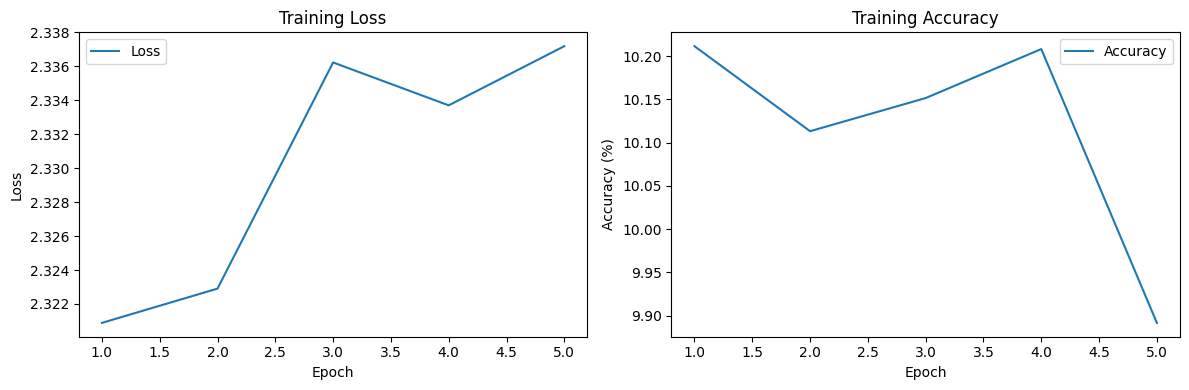


Final Stats - Pretrain Accuracy: 9.76%, Train Accuracy: 9.97%, Final Accuracy: 9.97%, Total Time: 4197.07s, Spike Count: -2030963.82421875, Pruned Neurons: 0


In [18]:
# Cell 6: Plotting Results
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, train_epochs+1), losses, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, train_epochs+1), accuracies, label='Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

print(f"\nFinal Stats - Pretrain Accuracy: {pretrain_accuracy:.2f}%, Train Accuracy: {train_accuracy:.2f}%, Final Accuracy: {final_accuracy:.2f}%, Total Time: {pretrain_time + training_time:.2f}s, Spike Count: {spike_count}, Pruned Neurons: {pruned_neurons}")